Loading necessary libraries

In [93]:
import sys
sys.path.append("..")
from tensorflow.python.summary.summary_iterator import summary_iterator
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib as mpl
import numpy as np

Disabling warnings for a clean preview. Comment the next block for the default state.

In [94]:
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = True

Necessary Variables

In [95]:
LOG_DIR = '../logs.hs3d/'
LOGS = []
ALL_DATA = {}
HIGH_QUALITY_IMAGES = False
image_format = 'svg'

In [96]:
font = {
    'weight': 'normal',
    'size': 16
}

mpl.rc('font', **font)

Here, we list the relevant log files from the training process

In [97]:
# Going through all files
for root, dirs, files in os.walk(LOG_DIR):
    for file in files:
        # Ignoring unnecessary results
        if root.find('logs') < 0:
            continue
        if not file.endswith('.v2'):
            continue
        if root.find('_level_') < 0:
            continue
        # Keeping the path to relevant files in memory
        LOGS.append(f'{root}/{file}')


Here we load the information within the log files into memory

In [98]:
# Loading the data from each relevant log file
for log in LOGS:
    ALL_DATA[log] = {'loss': [], 'accuracy': [], 'f1': [], 'auc_pr': [], 'start':None, 'end':None}
    for summary in summary_iterator(log):
        if not ALL_DATA[log]['start']:
            ALL_DATA[log]['start'] = float(summary.wall_time)
        ALL_DATA[log]['end'] = float(summary.wall_time)
        if len(summary.summary.value):
            if summary.summary.value[0].tag == 'epoch_loss':
                ALL_DATA[log]['loss'].append(summary.summary.value[0].simple_value)
            if summary.summary.value[0].tag == 'epoch_accuracy':
                ALL_DATA[log]['accuracy'].append(summary.summary.value[0].simple_value)
            if summary.summary.value[0].tag == 'epoch_f1':
                ALL_DATA[log]['f1'].append(summary.summary.value[0].simple_value)
            if summary.summary.value[0].tag == 'epoch_auc_pr':
                ALL_DATA[log]['auc_pr'].append(summary.summary.value[0].simple_value)

Some helper functions

In [99]:
# Function to load relevant data into a python array
def get_accuracy_data_numpy(exp_keys, key_include):
    arr = np.ndarray(shape=(0,len(ALL_DATA[exp_keys[0]]['accuracy'])))
    for key in exp_keys:
        if key_include not in key:
            continue
        arr = np.append(arr, [ALL_DATA[key]['accuracy']], axis=0)
    return arr

def get_f1_data_numpy(exp_keys, key_include):
    arr = np.ndarray(shape=(0,len(ALL_DATA[exp_keys[0]]['f1'])))
    for key in exp_keys:
        if key_include not in key:
            continue
        arr = np.append(arr, [ALL_DATA[key]['f1']], axis=0)
    return arr

def get_auc_pr_data_numpy(exp_keys, key_include):
    arr = np.ndarray(shape=(0,len(ALL_DATA[exp_keys[0]]['auc_pr'])))
    for key in exp_keys:
        if key_include not in key:
            continue
        arr = np.append(arr, [ALL_DATA[key]['auc_pr']], axis=0)
    return arr

# Function to load relevant time data
def get_time_in_seconds(exp_keys, key_include):
    times = []
    for key in exp_keys:
        if key_include not in key:
            continue
        times.append(ALL_DATA[key]['end']-ALL_DATA[key]['start'])
    return times

# Function for creating accuracy per epoch plots
def plot_all_and_average_accuracy(exp_keys, title=None, save=False):
    fig = plt.figure(dpi=300 if HIGH_QUALITY_IMAGES else 72, figsize=(7, 6))
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.rcParams['savefig.facecolor'] = 'w'

    ax = fig.gca()
    ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: '{:.0f} %'.format(x*100)))

    data_train = get_accuracy_data_numpy(exp_keys, 'train')
    data_valid = get_accuracy_data_numpy(exp_keys, 'valid')
    linewidth = 2

    for row in data_train:
        plt.plot(row, color='#E2EDF3', linewidth=linewidth)
    for row in data_valid:
        plt.plot(row, color='#E2F3F2', linewidth=linewidth)
    plt.plot(np.mean(data_train, axis=0), color='#4889AD', label='Average Training Accuracy', linewidth=linewidth)
    plt.plot(np.mean(data_valid, axis=0), color='#52B7B0',label='Average Validation Accuracy', linewidth=linewidth)

    plt.grid(axis='y')
    plt.legend(loc='lower right')
    if title:
        plt.title(title)
    if save:
        plt.savefig(save)
    else:
        plt.show()

# Function for creating f1 per epoch plots
def plot_all_and_average_f1(exp_keys, title=None, save=False):
    fig = plt.figure(dpi=300 if HIGH_QUALITY_IMAGES else 72, figsize=(7, 6))
    plt.ylabel('F1 Score')
    plt.xlabel('Epochs')
    plt.rcParams['savefig.facecolor'] = 'w'

    ax = fig.gca()
    # ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: '{:.0f}'.format(x*100)))

    data_train = get_f1_data_numpy(exp_keys, 'train')
    data_valid = get_f1_data_numpy(exp_keys, 'valid')
    linewidth = 2

    for row in data_train:
        plt.plot(row, color='#E2EDF3', linewidth=linewidth)
    for row in data_valid:
        plt.plot(row, color='#E2F3F2', linewidth=linewidth)
    plt.plot(np.mean(data_train, axis=0), color='#4889AD', label='Average Training F1 Score', linewidth=linewidth)
    plt.plot(np.mean(data_valid, axis=0), color='#52B7B0',label='Average Validation F1 Score', linewidth=linewidth)

    plt.grid(axis='y')
    plt.legend(loc='lower right')
    if title:
        plt.title(title)
    if save:
        plt.savefig(save)
    else:
        plt.show()

# Function for creating AUC PR per epoch plots
def plot_all_and_average_auc_pr(exp_keys, title=None, save=False):
    fig = plt.figure(dpi=300 if HIGH_QUALITY_IMAGES else 72, figsize=(7, 6))
    plt.ylabel('AUC PR')
    plt.xlabel('Epochs')
    plt.rcParams['savefig.facecolor'] = 'w'

    ax = fig.gca()
    # ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: '{:.0f}'.format(x*100)))

    data_train = get_auc_pr_data_numpy(exp_keys, 'train')
    data_valid = get_auc_pr_data_numpy(exp_keys, 'valid')
    linewidth = 2

    for row in data_train:
        plt.plot(row, color='#E2EDF3', linewidth=linewidth)
    for row in data_valid:
        plt.plot(row, color='#E2F3F2', linewidth=linewidth)
    plt.plot(np.mean(data_train, axis=0), color='#4889AD', label='Average Training AUC PR', linewidth=linewidth)
    plt.plot(np.mean(data_valid, axis=0), color='#52B7B0',label='Average Validation AUC PR', linewidth=linewidth)

    plt.grid(axis='y')
    plt.legend(loc='lower right')
    if title:
        plt.title(title)
    if save:
        plt.savefig(save)
    else:
        plt.show()

Creating Accuracy Per Epoch Plots for CNN Experiments

Average Training Time: 73.3775809764862, Average Validation Time: 72.07948377132416


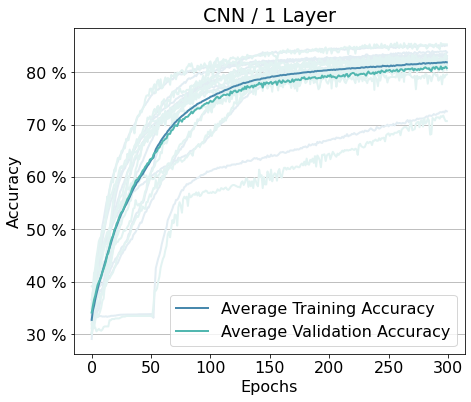

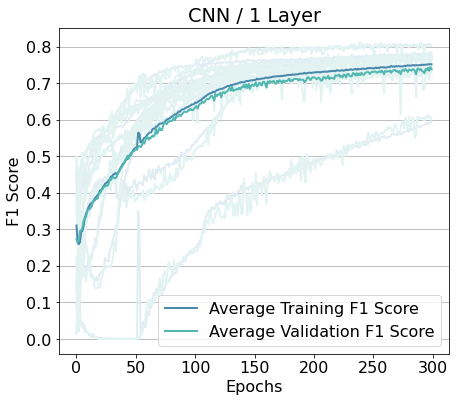

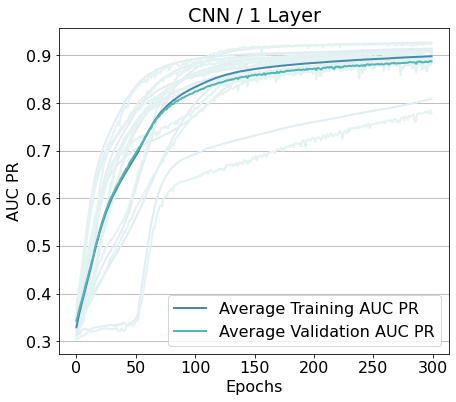

In [100]:
# CNN Experiment 1

cnn1 = []
for key in ALL_DATA.keys():
    if 'cnn_level_1/' in key:
        cnn1.append(key)

cnn1_train_time = np.mean(get_time_in_seconds(cnn1, 'train'))
cnn1_valid_time = np.mean(get_time_in_seconds(cnn1, 'valid'))
print(f'Average Training Time: {cnn1_train_time}, Average Validation Time: {cnn1_valid_time}')

plot_all_and_average_accuracy(cnn1, 'CNN / 1 Layer', save=f'cnn1_acc.{image_format}')
plot_all_and_average_f1(cnn1, 'CNN / 1 Layer', save=f'cnn1_f1.{image_format}')
plot_all_and_average_auc_pr(cnn1, 'CNN / 1 Layer', save=f'cnn1_auc_pr.{image_format}')

Average Training Time: 78.49854118824005, Average Validation Time: 77.20040969848633


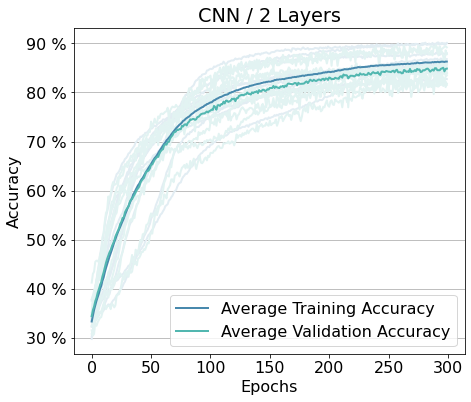

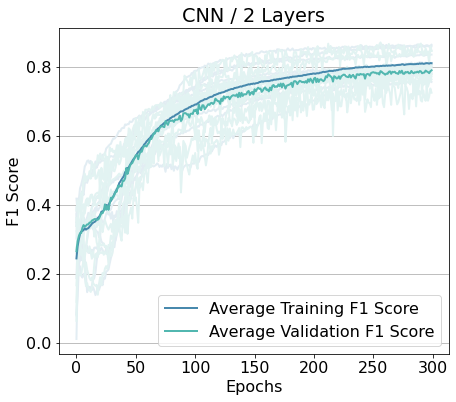

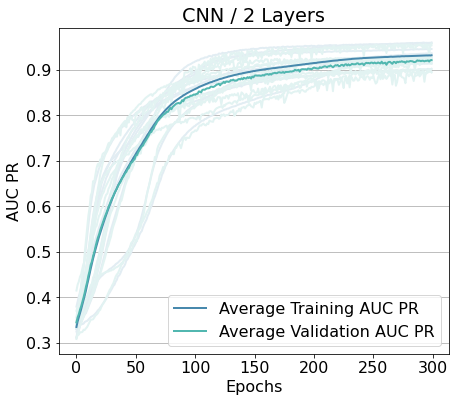

In [101]:
# CNN Experiment 2

cnn2 = []
for key in ALL_DATA.keys():
    if 'cnn_level_2/' in key:
        cnn2.append(key)

cnn2_train_time = np.mean(get_time_in_seconds(cnn2, 'train'))
cnn2_valid_time = np.mean(get_time_in_seconds(cnn2, 'valid'))
print(f'Average Training Time: {cnn2_train_time}, Average Validation Time: {cnn2_valid_time}')


plot_all_and_average_accuracy(cnn2, 'CNN / 2 Layers', save=f'cnn2_acc.{image_format}')
plot_all_and_average_f1(cnn2, 'CNN / 2 Layers', save=f'cnn2_f1.{image_format}')
plot_all_and_average_auc_pr(cnn2, 'CNN / 2 Layers', save=f'cnn2_auc_pr.{image_format}')

Average Training Time: 84.23279852867127, Average Validation Time: 82.834801197052


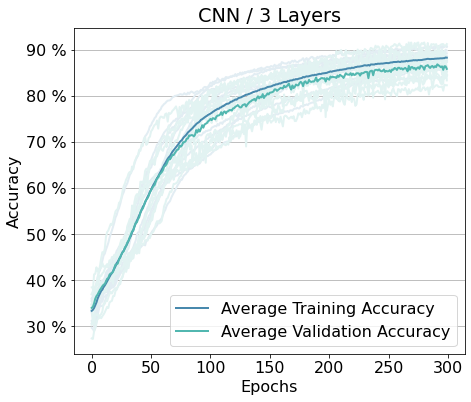

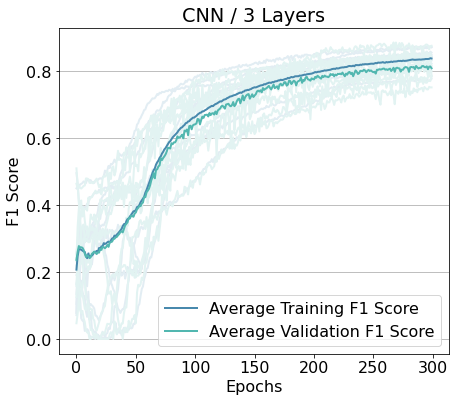

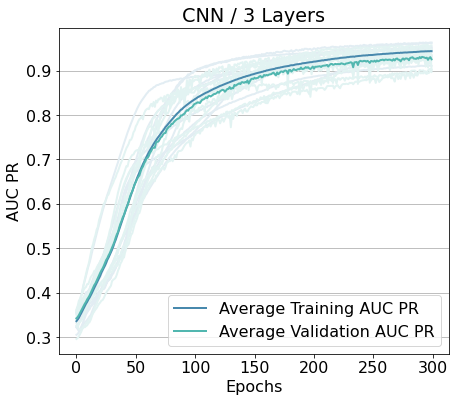

In [102]:
# CNN Experiment 3

cnn3 = []
for key in ALL_DATA.keys():
    if 'cnn_level_3/' in key:
        cnn3.append(key)
        
cnn3_train_time = np.mean(get_time_in_seconds(cnn3, 'train'))
cnn3_valid_time = np.mean(get_time_in_seconds(cnn3, 'valid'))
print(f'Average Training Time: {cnn3_train_time}, Average Validation Time: {cnn3_valid_time}')

plot_all_and_average_accuracy(cnn3, 'CNN / 3 Layers', save=f'cnn3_acc.{image_format}')
plot_all_and_average_f1(cnn3, 'CNN / 3 Layers', save=f'cnn3_f1.{image_format}')
plot_all_and_average_auc_pr(cnn3, 'CNN / 3 Layers', save=f'cnn3_auc_pr.{image_format}')

Average Training Time: 89.27567064762115, Average Validation Time: 87.77758169174194


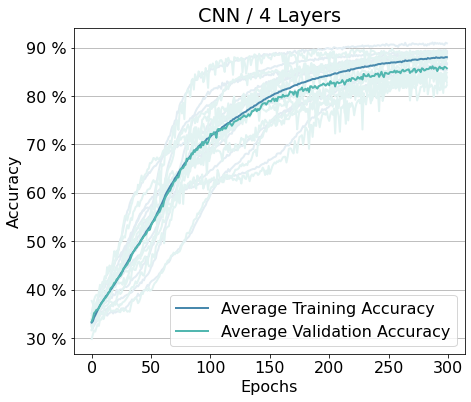

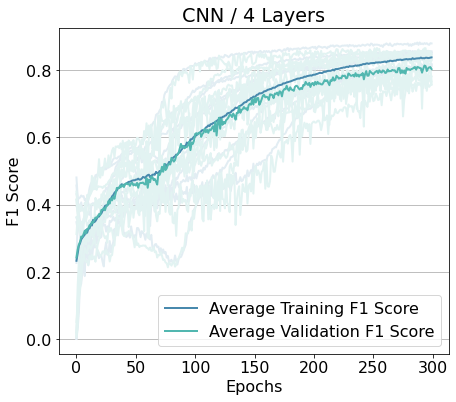

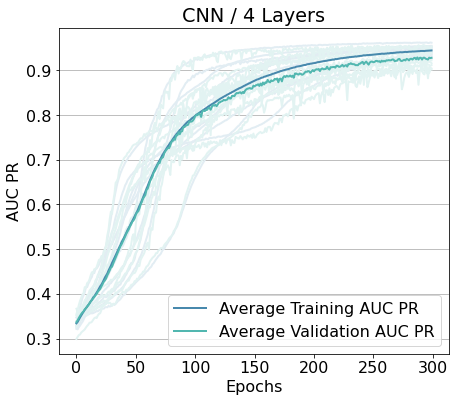

In [103]:
# CNN Experiment 4

cnn4 = []
for key in ALL_DATA.keys():
    if 'cnn_level_4/' in key:
        cnn4.append(key)
        
cnn4_train_time = np.mean(get_time_in_seconds(cnn4, 'train'))
cnn4_valid_time = np.mean(get_time_in_seconds(cnn4, 'valid'))
print(f'Average Training Time: {cnn4_train_time}, Average Validation Time: {cnn4_valid_time}')

plot_all_and_average_accuracy(cnn4, 'CNN / 4 Layers', save=f'cnn4_acc.{image_format}')
plot_all_and_average_f1(cnn4, 'CNN / 4 Layers', save=f'cnn4_f1.{image_format}')
plot_all_and_average_auc_pr(cnn4, 'CNN / 4 Layers', save=f'cnn4_auc_pr.{image_format}')

Average Training Time: 93.35096716880798, Average Validation Time: 92.15293874740601


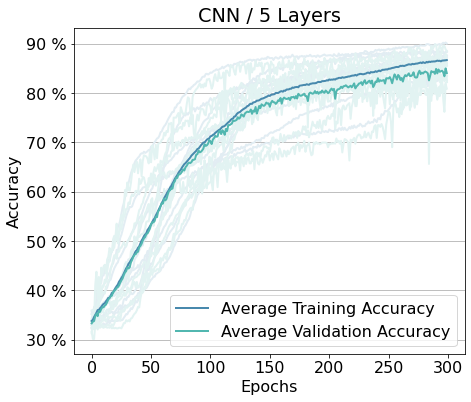

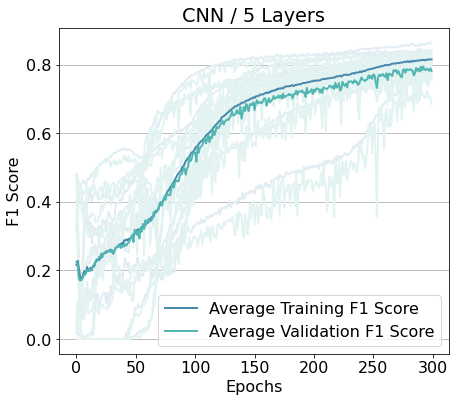

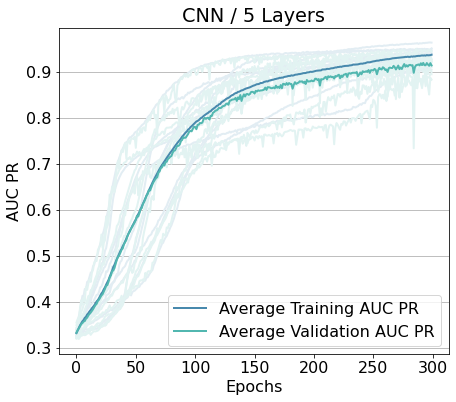

In [104]:
# CNN Experiment 5

cnn5 = []
for key in ALL_DATA.keys():
    if 'cnn_level_5/' in key:
        cnn5.append(key)
        
cnn5_train_time = np.mean(get_time_in_seconds(cnn5, 'train'))
cnn5_valid_time = np.mean(get_time_in_seconds(cnn5, 'valid'))
print(f'Average Training Time: {cnn5_train_time}, Average Validation Time: {cnn5_valid_time}')

plot_all_and_average_accuracy(cnn5, 'CNN / 5 Layers', save=f'cnn5_acc.{image_format}')
plot_all_and_average_f1(cnn5, 'CNN / 5 Layers', save=f'cnn5_f1.{image_format}')
plot_all_and_average_auc_pr(cnn5, 'CNN / 5 Layers', save=f'cnn5_auc_pr.{image_format}')

Saving the maximum average accuracy and run time per experiment for later analysis

In [105]:
acc_data_layer_1 = get_accuracy_data_numpy(cnn1, 'valid')
acc_data_layer_2 = get_accuracy_data_numpy(cnn2, 'valid')
acc_data_layer_3 = get_accuracy_data_numpy(cnn3, 'valid')
acc_data_layer_4 = get_accuracy_data_numpy(cnn4, 'valid')
acc_data_layer_5 = get_accuracy_data_numpy(cnn5, 'valid')

acc_mean_1 = np.max(np.mean(acc_data_layer_1, axis=0))
acc_mean_2 = np.max(np.mean(acc_data_layer_2, axis=0))
acc_mean_3 = np.max(np.mean(acc_data_layer_3, axis=0))
acc_mean_4 = np.max(np.mean(acc_data_layer_4, axis=0))
acc_mean_5 = np.max(np.mean(acc_data_layer_5, axis=0))
acc_cnn_arr_mean = [acc_mean_1, acc_mean_2, acc_mean_3, acc_mean_4, acc_mean_5]

acc_max_1 = np.max(acc_data_layer_1)
acc_max_2 = np.max(acc_data_layer_2)
acc_max_3 = np.max(acc_data_layer_3)
acc_max_4 = np.max(acc_data_layer_4)
acc_max_5 = np.max(acc_data_layer_5)
acc_cnn_arr_max = [acc_max_1, acc_max_2, acc_max_3, acc_max_4, acc_max_5]

In [106]:
f1_data_layer_1 = get_f1_data_numpy(cnn1, 'valid')
f1_data_layer_2 = get_f1_data_numpy(cnn2, 'valid')
f1_data_layer_3 = get_f1_data_numpy(cnn3, 'valid')
f1_data_layer_4 = get_f1_data_numpy(cnn4, 'valid')
f1_data_layer_5 = get_f1_data_numpy(cnn5, 'valid')

f1_mean_1 = np.max(np.mean(f1_data_layer_1, axis=0))
f1_mean_2 = np.max(np.mean(f1_data_layer_2, axis=0))
f1_mean_3 = np.max(np.mean(f1_data_layer_3, axis=0))
f1_mean_4 = np.max(np.mean(f1_data_layer_4, axis=0))
f1_mean_5 = np.max(np.mean(f1_data_layer_5, axis=0))
f1_cnn_arr_mean = [f1_mean_1, f1_mean_2, f1_mean_3, f1_mean_4, f1_mean_5]

f1_max_1 = np.max(f1_data_layer_1)
f1_max_2 = np.max(f1_data_layer_2)
f1_max_3 = np.max(f1_data_layer_3)
f1_max_4 = np.max(f1_data_layer_4)
f1_max_5 = np.max(f1_data_layer_5)
f1_cnn_arr_max = [f1_max_1, f1_max_2, f1_max_3, f1_max_4, f1_max_5]

In [107]:
auc_pr_data_layer_1 = get_auc_pr_data_numpy(cnn1, 'valid')
auc_pr_data_layer_2 = get_auc_pr_data_numpy(cnn2, 'valid')
auc_pr_data_layer_3 = get_auc_pr_data_numpy(cnn3, 'valid')
auc_pr_data_layer_4 = get_auc_pr_data_numpy(cnn4, 'valid')
auc_pr_data_layer_5 = get_auc_pr_data_numpy(cnn5, 'valid')

auc_pr_mean_1 = np.max(np.mean(auc_pr_data_layer_1, axis=0))
auc_pr_mean_2 = np.max(np.mean(auc_pr_data_layer_2, axis=0))
auc_pr_mean_3 = np.max(np.mean(auc_pr_data_layer_3, axis=0))
auc_pr_mean_4 = np.max(np.mean(auc_pr_data_layer_4, axis=0))
auc_pr_mean_5 = np.max(np.mean(auc_pr_data_layer_5, axis=0))
auc_pr_cnn_arr_mean = [auc_pr_mean_1, auc_pr_mean_2, auc_pr_mean_3, auc_pr_mean_4, auc_pr_mean_5]

auc_pr_max_1 = np.max(auc_pr_data_layer_1)
auc_pr_max_2 = np.max(auc_pr_data_layer_2)
auc_pr_max_3 = np.max(auc_pr_data_layer_3)
auc_pr_max_4 = np.max(auc_pr_data_layer_4)
auc_pr_max_5 = np.max(auc_pr_data_layer_5)
auc_pr_cnn_arr_max = [auc_pr_max_1, auc_pr_max_2, auc_pr_max_3, auc_pr_max_4, auc_pr_max_5]

In [108]:
cnn_time = [cnn1_train_time, cnn2_train_time, cnn3_train_time, cnn4_train_time, cnn5_train_time]

Creating Accuracy Per Epoch Plots for BLSTM Experiments

Average Training Time: 246.911975979805, Average Validation Time: 243.51403260231018


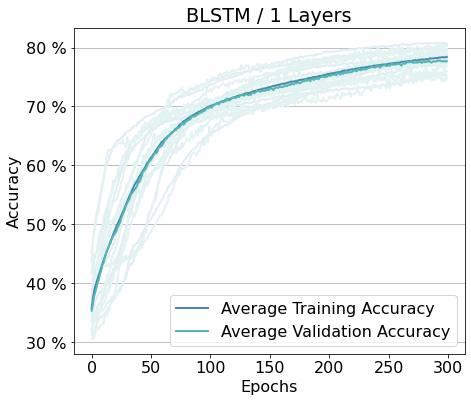

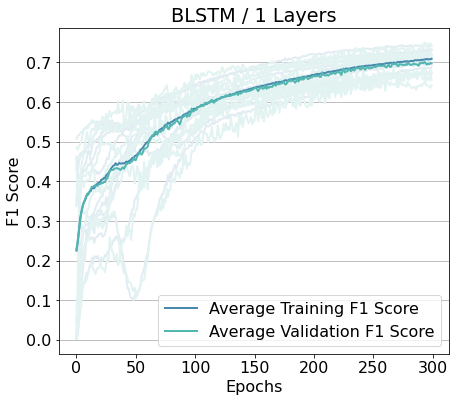

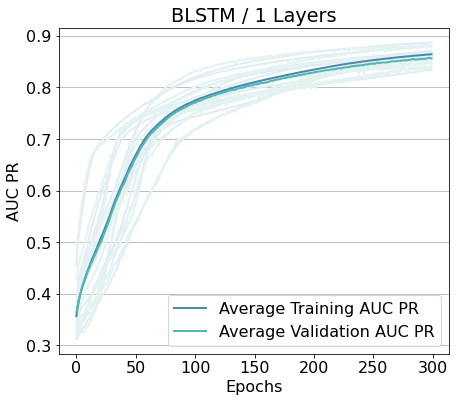

In [109]:
# BLSTM Experiment 1

blstm1 = []
for key in ALL_DATA.keys():
    if 'blstm_level_1/' in key:
        blstm1.append(key)
        
blstm1_train_time = np.mean(get_time_in_seconds(blstm1, 'train'))
blstm1_valid_time = np.mean(get_time_in_seconds(blstm1, 'valid'))
print(f'Average Training Time: {blstm1_train_time}, Average Validation Time: {blstm1_valid_time}')

plot_all_and_average_accuracy(blstm1, 'BLSTM / 1 Layers', save=f'blstm1_acc.{image_format}')
plot_all_and_average_f1(blstm1, 'BLSTM / 1 Layers', save=f'blstm1_f1.{image_format}')
plot_all_and_average_auc_pr(blstm1, 'BLSTM / 1 Layers', save=f'blstm1_auc_pr.{image_format}')

Average Training Time: 407.70093672275544, Average Validation Time: 402.4028908967972


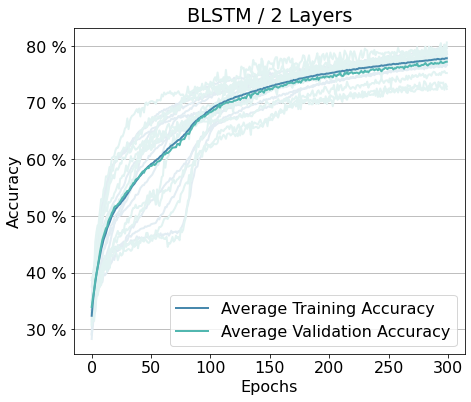

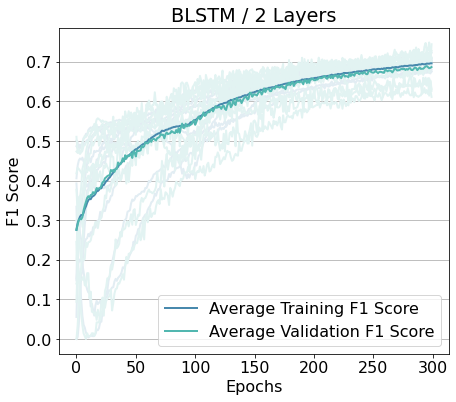

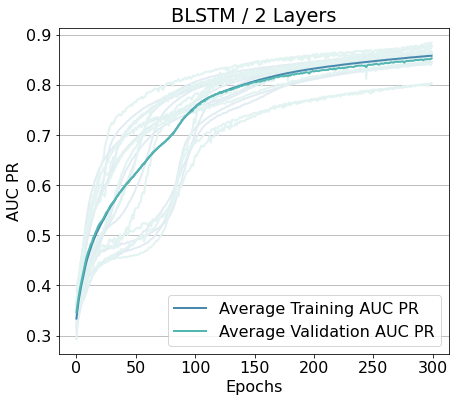

In [110]:
# BLSTM Experiment 2

blstm2 = []
for key in ALL_DATA.keys():
    if 'blstm_level_2/' in key:
        blstm2.append(key)
        
blstm2_train_time = np.mean(get_time_in_seconds(blstm2, 'train'))
blstm2_valid_time = np.mean(get_time_in_seconds(blstm2, 'valid'))
print(f'Average Training Time: {blstm2_train_time}, Average Validation Time: {blstm2_valid_time}')

plot_all_and_average_accuracy(blstm2, 'BLSTM / 2 Layers', save=f'blstm2_acc.{image_format}')
plot_all_and_average_f1(blstm2, 'BLSTM / 2 Layers', save=f'blstm2_f1.{image_format}')
plot_all_and_average_auc_pr(blstm2, 'BLSTM / 2 Layers', save=f'blstm2_auc_pr.{image_format}')

Average Training Time: 571.9469795465469, Average Validation Time: 564.2489053726197


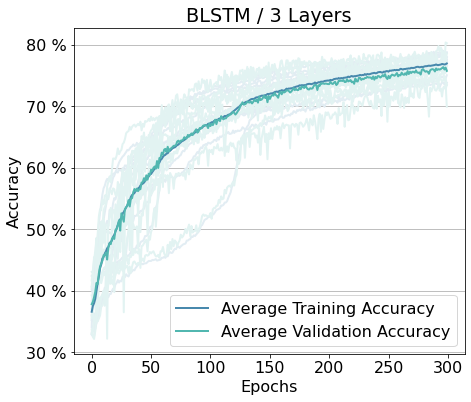

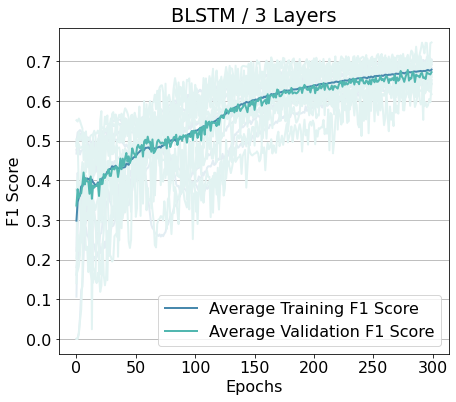

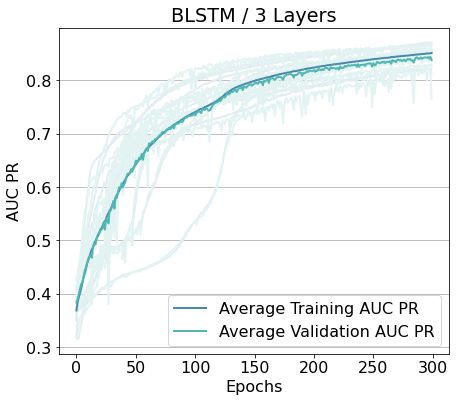

In [111]:
# BLSTM Experiment 3

blstm3 = []
for key in ALL_DATA.keys():
    if 'blstm_level_3/' in key:
        blstm3.append(key)
        
blstm3_train_time = np.mean(get_time_in_seconds(blstm3, 'train'))
blstm3_valid_time = np.mean(get_time_in_seconds(blstm3, 'valid'))
print(f'Average Training Time: {blstm3_train_time}, Average Validation Time: {blstm3_valid_time}')

plot_all_and_average_accuracy(blstm3,'BLSTM / 3 Layers', save=f'blstm3_acc.{image_format}')
plot_all_and_average_f1(blstm3,'BLSTM / 3 Layers', save=f'blstm3_f1.{image_format}')
plot_all_and_average_auc_pr(blstm3,'BLSTM / 3 Layers', save=f'blstm3_auc_pr.{image_format}')

Average Training Time: 738.689712715149, Average Validation Time: 728.591655087471


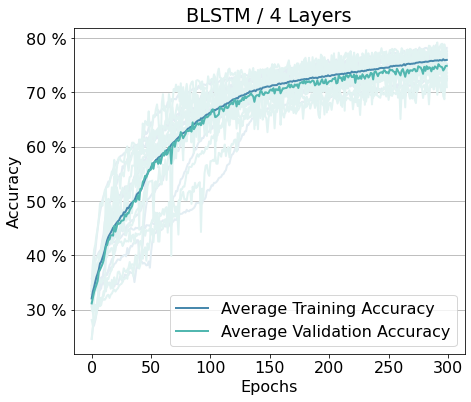

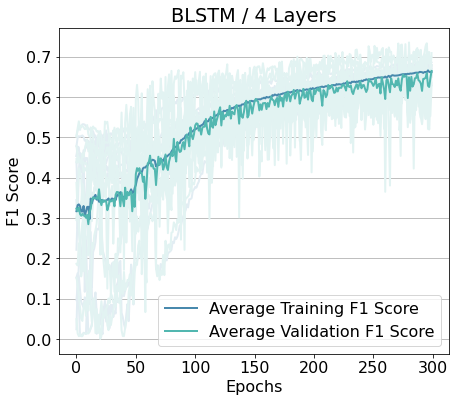

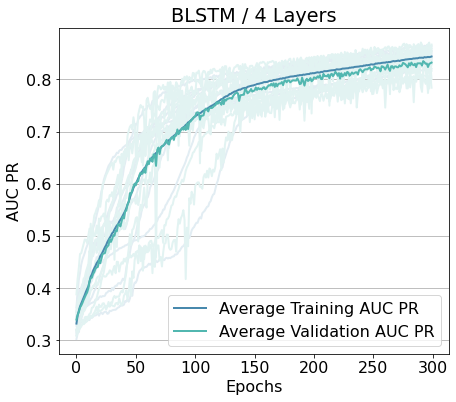

In [112]:
# BLSTM Experiment 4

blstm4 = []
for key in ALL_DATA.keys():
    if 'blstm_level_4/' in key:
        blstm4.append(key)
        
blstm4_train_time = np.mean(get_time_in_seconds(blstm4, 'train'))
blstm4_valid_time = np.mean(get_time_in_seconds(blstm4, 'valid'))
print(f'Average Training Time: {blstm4_train_time}, Average Validation Time: {blstm4_valid_time}')

plot_all_and_average_accuracy(blstm4, 'BLSTM / 4 Layers', save=f'blstm4_acc.{image_format}')
plot_all_and_average_f1(blstm4, 'BLSTM / 4 Layers', save=f'blstm4_f1.{image_format}')
plot_all_and_average_auc_pr(blstm4, 'BLSTM / 4 Layers', save=f'blstm4_auc_pr.{image_format}')

Average Training Time: 922.0665251970291, Average Validation Time: 910.0682963132858


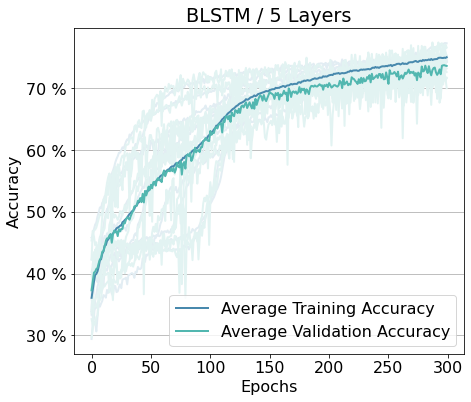

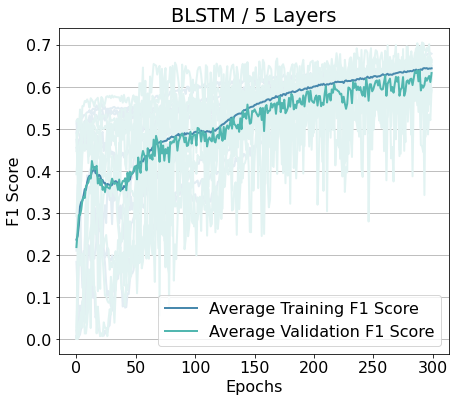

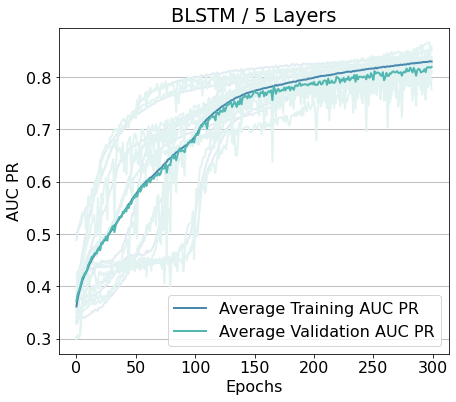

In [113]:
# BLSTM Experiment 5

blstm5 = []
for key in ALL_DATA.keys():
    if 'blstm_level_5/' in key:
        blstm5.append(key)
        
blstm5_train_time = np.mean(get_time_in_seconds(blstm5, 'train'))
blstm5_valid_time = np.mean(get_time_in_seconds(blstm5, 'valid'))
print(f'Average Training Time: {blstm5_train_time}, Average Validation Time: {blstm5_valid_time}')

plot_all_and_average_accuracy(blstm5, 'BLSTM / 5 Layers', save=f'blstm5_acc.{image_format}')
plot_all_and_average_f1(blstm5, 'BLSTM / 5 Layers', save=f'blstm5_f1.{image_format}')
plot_all_and_average_auc_pr(blstm5, 'BLSTM / 5 Layers', save=f'blstm5_auc_pr.{image_format}')

Saving the maximum average accuracy and run time per experiment for later analysis

In [114]:
acc_data_layer_1 = get_accuracy_data_numpy(blstm1, 'valid')
acc_data_layer_2 = get_accuracy_data_numpy(blstm2, 'valid')
acc_data_layer_3 = get_accuracy_data_numpy(blstm3, 'valid')
acc_data_layer_4 = get_accuracy_data_numpy(blstm4, 'valid')
acc_data_layer_5 = get_accuracy_data_numpy(blstm5, 'valid')

acc_mean_1 = np.max(np.mean(acc_data_layer_1, axis=0))
acc_mean_2 = np.max(np.mean(acc_data_layer_2, axis=0))
acc_mean_3 = np.max(np.mean(acc_data_layer_3, axis=0))
acc_mean_4 = np.max(np.mean(acc_data_layer_4, axis=0))
acc_mean_5 = np.max(np.mean(acc_data_layer_5, axis=0))
acc_blstm_arr_mean = [acc_mean_1, acc_mean_2, acc_mean_3, acc_mean_4, acc_mean_5]

acc_max_1 = np.max(acc_data_layer_1)
acc_max_2 = np.max(acc_data_layer_2)
acc_max_3 = np.max(acc_data_layer_3)
acc_max_4 = np.max(acc_data_layer_4)
acc_max_5 = np.max(acc_data_layer_5)
acc_blstm_arr_max = [acc_max_1, acc_max_2, acc_max_3, acc_max_4, acc_max_5]

In [115]:
f1_data_layer_1 = get_f1_data_numpy(blstm1, 'valid')
f1_data_layer_2 = get_f1_data_numpy(blstm2, 'valid')
f1_data_layer_3 = get_f1_data_numpy(blstm3, 'valid')
f1_data_layer_4 = get_f1_data_numpy(blstm4, 'valid')
f1_data_layer_5 = get_f1_data_numpy(blstm5, 'valid')

f1_mean_1 = np.max(np.mean(f1_data_layer_1, axis=0))
f1_mean_2 = np.max(np.mean(f1_data_layer_2, axis=0))
f1_mean_3 = np.max(np.mean(f1_data_layer_3, axis=0))
f1_mean_4 = np.max(np.mean(f1_data_layer_4, axis=0))
f1_mean_5 = np.max(np.mean(f1_data_layer_5, axis=0))
f1_blstm_arr_mean = [f1_mean_1, f1_mean_2, f1_mean_3, f1_mean_4, f1_mean_5]

f1_max_1 = np.max(f1_data_layer_1)
f1_max_2 = np.max(f1_data_layer_2)
f1_max_3 = np.max(f1_data_layer_3)
f1_max_4 = np.max(f1_data_layer_4)
f1_max_5 = np.max(f1_data_layer_5)
f1_blstm_arr_max = [f1_max_1, f1_max_2, f1_max_3, f1_max_4, f1_max_5]

In [116]:
auc_pr_data_layer_1 = get_auc_pr_data_numpy(blstm1, 'valid')
auc_pr_data_layer_2 = get_auc_pr_data_numpy(blstm2, 'valid')
auc_pr_data_layer_3 = get_auc_pr_data_numpy(blstm3, 'valid')
auc_pr_data_layer_4 = get_auc_pr_data_numpy(blstm4, 'valid')
auc_pr_data_layer_5 = get_auc_pr_data_numpy(blstm5, 'valid')

auc_pr_mean_1 = np.max(np.mean(auc_pr_data_layer_1, axis=0))
auc_pr_mean_2 = np.max(np.mean(auc_pr_data_layer_2, axis=0))
auc_pr_mean_3 = np.max(np.mean(auc_pr_data_layer_3, axis=0))
auc_pr_mean_4 = np.max(np.mean(auc_pr_data_layer_4, axis=0))
auc_pr_mean_5 = np.max(np.mean(auc_pr_data_layer_5, axis=0))
auc_pr_blstm_arr_mean = [auc_pr_mean_1, auc_pr_mean_2, auc_pr_mean_3, auc_pr_mean_4, auc_pr_mean_5]

auc_pr_max_1 = np.max(auc_pr_data_layer_1)
auc_pr_max_2 = np.max(auc_pr_data_layer_2)
auc_pr_max_3 = np.max(auc_pr_data_layer_3)
auc_pr_max_4 = np.max(auc_pr_data_layer_4)
auc_pr_max_5 = np.max(auc_pr_data_layer_5)
auc_pr_blstm_arr_max = [auc_pr_max_1, auc_pr_max_2, auc_pr_max_3, auc_pr_max_4, auc_pr_max_5]

In [117]:
blstm_time = [blstm1_train_time, blstm2_train_time, blstm3_train_time, blstm4_train_time, blstm5_train_time]

Creating Accuracy Per Epoch Plots for BLSTM Extended Experiments

Average Training Time: 815.9308955192566, Average Validation Time: 812.5329375982285


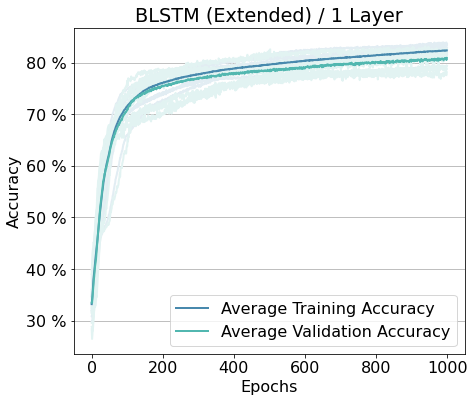

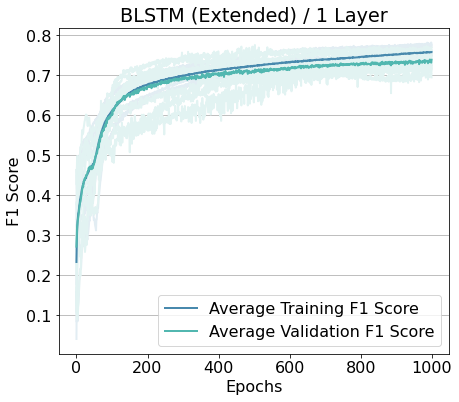

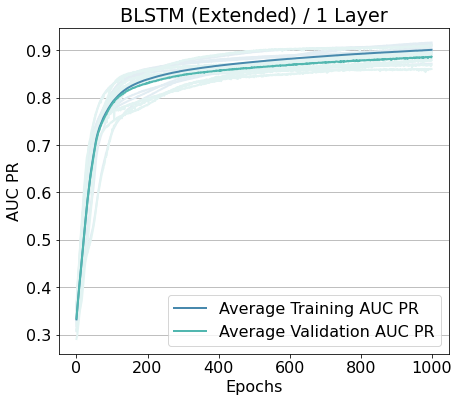

In [118]:
# BLSTM Extended Experiment 1

blstm1 = []
for key in ALL_DATA.keys():
    if 'blstm_level_1_extended/' in key:
        blstm1.append(key)
        
blstm1_train_time = np.mean(get_time_in_seconds(blstm1, 'train'))
blstm1_valid_time = np.mean(get_time_in_seconds(blstm1, 'valid'))
print(f'Average Training Time: {blstm1_train_time}, Average Validation Time: {blstm1_valid_time}')

plot_all_and_average_accuracy(blstm1, 'BLSTM (Extended) / 1 Layer', save=f'blstm1_ext_acc.{image_format}')
plot_all_and_average_f1(blstm1, 'BLSTM (Extended) / 1 Layer', save=f'blstm1_ext_f1.{image_format}')
plot_all_and_average_auc_pr(blstm1, 'BLSTM (Extended) / 1 Layer', save=f'blstm1_ext_auc_pr.{image_format}')

Average Training Time: 1357.7669924020768, Average Validation Time: 1352.1688793897629


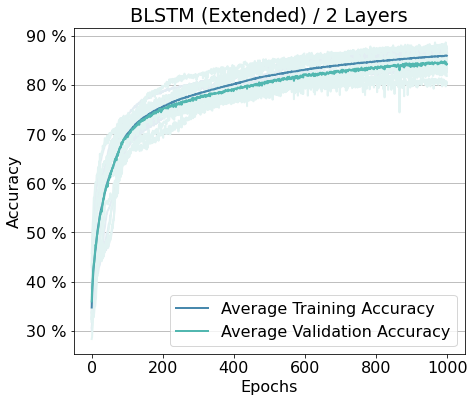

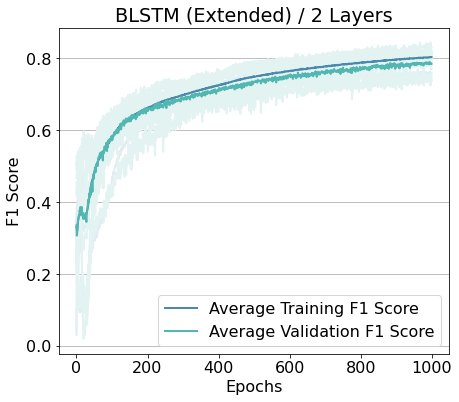

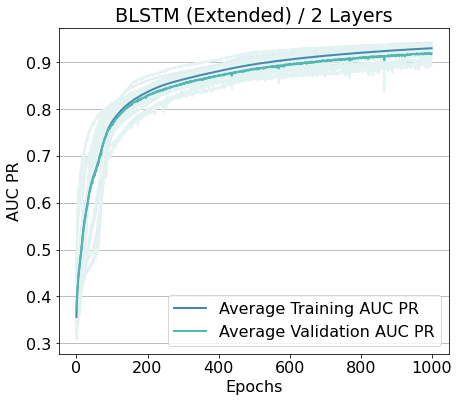

In [119]:
# BLSTM Extended Experiment 2

blstm2 = []
for key in ALL_DATA.keys():
    if 'blstm_level_2_extended/' in key:
        blstm2.append(key)
        
blstm2_train_time = np.mean(get_time_in_seconds(blstm2, 'train'))
blstm2_valid_time = np.mean(get_time_in_seconds(blstm2, 'valid'))
print(f'Average Training Time: {blstm2_train_time}, Average Validation Time: {blstm2_valid_time}')

plot_all_and_average_accuracy(blstm2,'BLSTM (Extended) / 2 Layers', save=f'blstm2_ext_acc.{image_format}')
plot_all_and_average_f1(blstm2,'BLSTM (Extended) / 2 Layers', save=f'blstm2_ext_f1.{image_format}')
plot_all_and_average_auc_pr(blstm2,'BLSTM (Extended) / 2 Layers', save=f'blstm2_ext_auc_pr.{image_format}')

Average Training Time: 1886.2275348901749, Average Validation Time: 1878.5293873548508


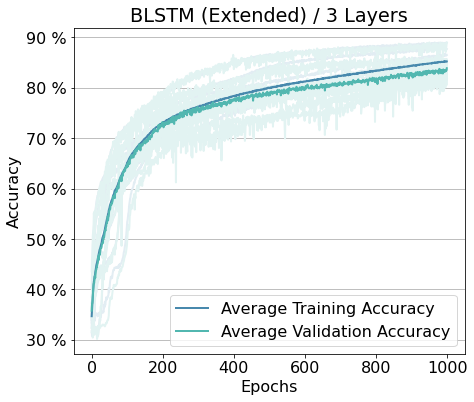

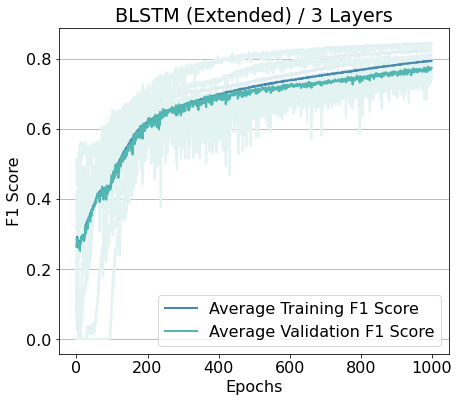

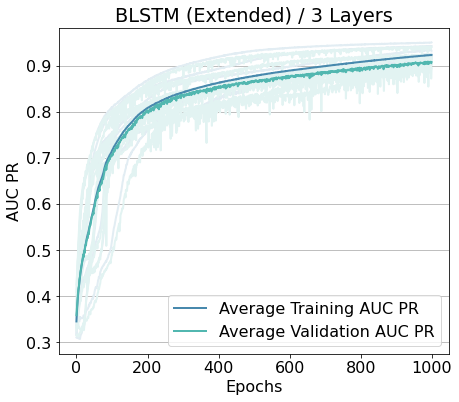

In [120]:
# BLSTM Extended Experiment 3

blstm3 = []
for key in ALL_DATA.keys():
    if 'blstm_level_3_extended/' in key:
        blstm3.append(key)
        
blstm3_train_time = np.mean(get_time_in_seconds(blstm3, 'train'))
blstm3_valid_time = np.mean(get_time_in_seconds(blstm3, 'valid'))
print(f'Average Training Time: {blstm3_train_time}, Average Validation Time: {blstm3_valid_time}')

plot_all_and_average_accuracy(blstm3, 'BLSTM (Extended) / 3 Layers', save=f'blstm3_ext_acc.{image_format}')
plot_all_and_average_f1(blstm3, 'BLSTM (Extended) / 3 Layers', save=f'blstm3_ext_f1.{image_format}')
plot_all_and_average_auc_pr(blstm3, 'BLSTM (Extended) / 3 Layers', save=f'blstm3_ext_auc_pr.{image_format}')

Average Training Time: 2475.236369585991, Average Validation Time: 2465.338264989853


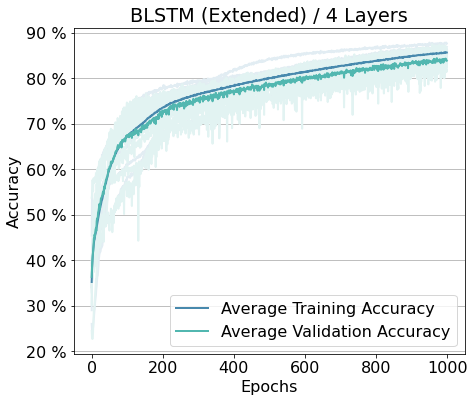

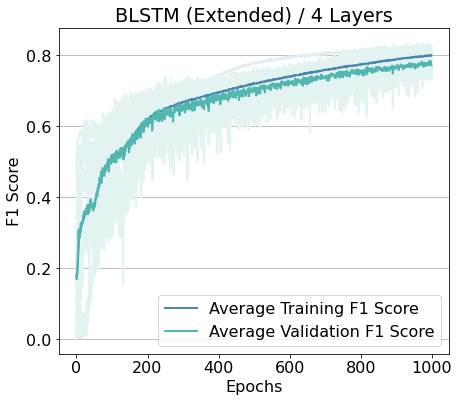

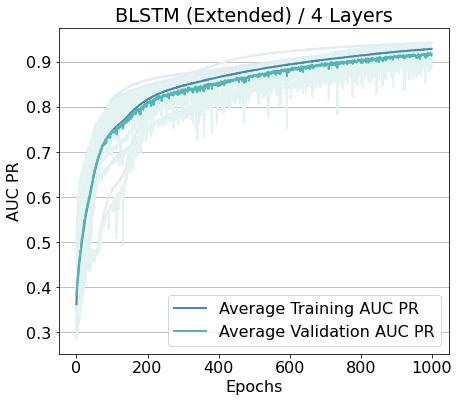

In [121]:
# BLSTM Extended Experiment 4

blstm4 = []
for key in ALL_DATA.keys():
    if 'blstm_level_4_extended/' in key:
        blstm4.append(key)
        
blstm4_train_time = np.mean(get_time_in_seconds(blstm4, 'train'))
blstm4_valid_time = np.mean(get_time_in_seconds(blstm4, 'valid'))
print(f'Average Training Time: {blstm4_train_time}, Average Validation Time: {blstm4_valid_time}')

plot_all_and_average_accuracy(blstm4, 'BLSTM (Extended) / 4 Layers', save=f'blstm4_ext_acc.{image_format}')
plot_all_and_average_f1(blstm4, 'BLSTM (Extended) / 4 Layers', save=f'blstm4_ext_f1.{image_format}')
plot_all_and_average_auc_pr(blstm4, 'BLSTM (Extended) / 4 Layers', save=f'blstm4_ext_auc_pr.{image_format}')

Average Training Time: 3048.596109080315, Average Validation Time: 3035.9979675531386


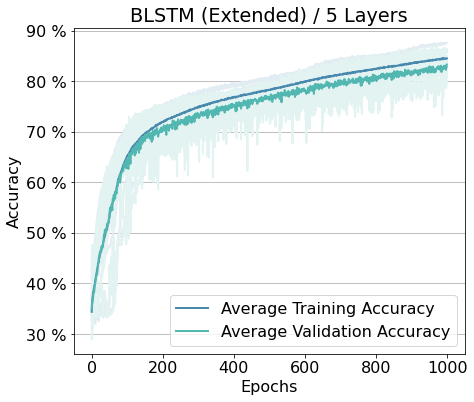

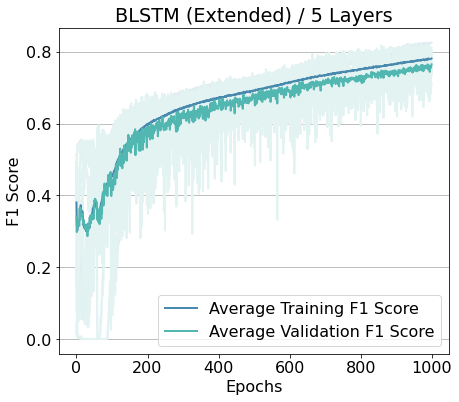

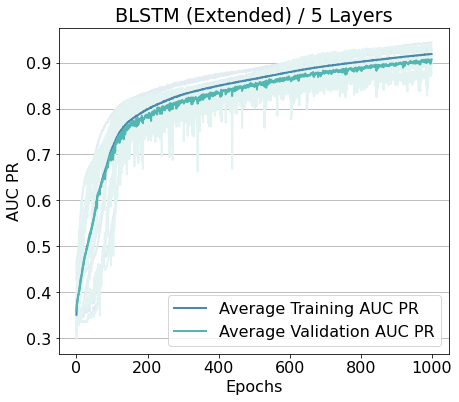

In [122]:
# BLSTM Extended Experiment 5

blstm5 = []
for key in ALL_DATA.keys():
    if 'blstm_level_5_extended/' in key:
        blstm5.append(key)
        
blstm5_train_time = np.mean(get_time_in_seconds(blstm5, 'train'))
blstm5_valid_time = np.mean(get_time_in_seconds(blstm5, 'valid'))
print(f'Average Training Time: {blstm5_train_time}, Average Validation Time: {blstm5_valid_time}')

plot_all_and_average_accuracy(blstm5, 'BLSTM (Extended) / 5 Layers', save=f'blstm5_ext_acc.{image_format}')
plot_all_and_average_f1(blstm5, 'BLSTM (Extended) / 5 Layers', save=f'blstm5_ext_f1.{image_format}')
plot_all_and_average_auc_pr(blstm5, 'BLSTM (Extended) / 5 Layers', save=f'blstm5_ext_auc_pr.{image_format}')

Saving the maximum average accuracy and run time per experiment for later analysis

In [123]:
acc_data_layer_1 = get_f1_data_numpy(blstm1, 'valid')
acc_data_layer_2 = get_f1_data_numpy(blstm2, 'valid')
acc_data_layer_3 = get_f1_data_numpy(blstm3, 'valid')
acc_data_layer_4 = get_f1_data_numpy(blstm4, 'valid')
acc_data_layer_5 = get_f1_data_numpy(blstm5, 'valid')

acc_mean_1 = np.max(np.mean(acc_data_layer_1, axis=0))
acc_mean_2 = np.max(np.mean(acc_data_layer_2, axis=0))
acc_mean_3 = np.max(np.mean(acc_data_layer_3, axis=0))
acc_mean_4 = np.max(np.mean(acc_data_layer_4, axis=0))
acc_mean_5 = np.max(np.mean(acc_data_layer_5, axis=0))
acc_blstm_ext_arr_mean = [acc_mean_1, acc_mean_2, acc_mean_3, acc_mean_4, acc_mean_5]

acc_max_1 = np.max(acc_data_layer_1)
acc_max_2 = np.max(acc_data_layer_2)
acc_max_3 = np.max(acc_data_layer_3)
acc_max_4 = np.max(acc_data_layer_4)
acc_max_5 = np.max(acc_data_layer_5)
acc_blstm_ext_arr_max = [acc_max_1, acc_max_2, acc_max_3, acc_max_4, acc_max_5]

In [124]:
f1_data_layer_1 = get_f1_data_numpy(blstm1, 'valid')
f1_data_layer_2 = get_f1_data_numpy(blstm2, 'valid')
f1_data_layer_3 = get_f1_data_numpy(blstm3, 'valid')
f1_data_layer_4 = get_f1_data_numpy(blstm4, 'valid')
f1_data_layer_5 = get_f1_data_numpy(blstm5, 'valid')

f1_mean_1 = np.max(np.mean(f1_data_layer_1, axis=0))
f1_mean_2 = np.max(np.mean(f1_data_layer_2, axis=0))
f1_mean_3 = np.max(np.mean(f1_data_layer_3, axis=0))
f1_mean_4 = np.max(np.mean(f1_data_layer_4, axis=0))
f1_mean_5 = np.max(np.mean(f1_data_layer_5, axis=0))
f1_blstm_ext_arr_mean = [f1_mean_1, f1_mean_2, f1_mean_3, f1_mean_4, f1_mean_5]

f1_max_1 = np.max(f1_data_layer_1)
f1_max_2 = np.max(f1_data_layer_2)
f1_max_3 = np.max(f1_data_layer_3)
f1_max_4 = np.max(f1_data_layer_4)
f1_max_5 = np.max(f1_data_layer_5)
f1_blstm_ext_arr_max = [f1_max_1, f1_max_2, f1_max_3, f1_max_4, f1_max_5]

In [125]:
auc_pr_data_layer_1 = get_auc_pr_data_numpy(blstm1, 'valid')
auc_pr_data_layer_2 = get_auc_pr_data_numpy(blstm2, 'valid')
auc_pr_data_layer_3 = get_auc_pr_data_numpy(blstm3, 'valid')
auc_pr_data_layer_4 = get_auc_pr_data_numpy(blstm4, 'valid')
auc_pr_data_layer_5 = get_auc_pr_data_numpy(blstm5, 'valid')

auc_pr_mean_1 = np.max(np.mean(auc_pr_data_layer_1, axis=0))
auc_pr_mean_2 = np.max(np.mean(auc_pr_data_layer_2, axis=0))
auc_pr_mean_3 = np.max(np.mean(auc_pr_data_layer_3, axis=0))
auc_pr_mean_4 = np.max(np.mean(auc_pr_data_layer_4, axis=0))
auc_pr_mean_5 = np.max(np.mean(auc_pr_data_layer_5, axis=0))
auc_pr_blstm_ext_arr_mean = [auc_pr_mean_1, auc_pr_mean_2, auc_pr_mean_3, auc_pr_mean_4, auc_pr_mean_5]

auc_pr_max_1 = np.max(auc_pr_data_layer_1)
auc_pr_max_2 = np.max(auc_pr_data_layer_2)
auc_pr_max_3 = np.max(auc_pr_data_layer_3)
auc_pr_max_4 = np.max(auc_pr_data_layer_4)
auc_pr_max_5 = np.max(auc_pr_data_layer_5)
auc_pr_blstm_ext_arr_max = [auc_pr_max_1, auc_pr_max_2, auc_pr_max_3, auc_pr_max_4, auc_pr_max_5]

In [126]:
blstm_ext_time = [blstm1_train_time, blstm2_train_time, blstm3_train_time, blstm4_train_time, blstm5_train_time]

Helper function to plot average training time and average accuracy per increasing layers for different experiment types

In [127]:
labels = ['1 Layer', '2 Layers', '3 Layers', '4 Layers', '5 Layers']
colors = ['#4889AD', '#4889AD', '#4889AD']
markers = ['d', 's', 'o']
linestyles = ['-', '--', '-.']
x = [0, 1, 2, 3, 4]

def plot_time_per_layer(data, save=False):
    fig = plt.figure(dpi=300 if HIGH_QUALITY_IMAGES else 72, figsize=(7, 6))
    plt.xticks(x, labels, rotation='0')
    plt.ylabel('Average Training Time (Seconds)')
    plt.rcParams['savefig.facecolor'] = 'w'
    plt.grid(axis='y')
    plt.grid(axis='y', which='minor', lw=0.5, c='#ccc')
    ax = fig.gca()
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: f'{x:.0f}'))
    ax.yaxis.set_minor_formatter(tick.FuncFormatter(lambda x,y: f'{x:.0f}'))
    ax.tick_params(axis='both', which='minor', labelsize=5)
    for idx, item in enumerate(data):
        plt.plot(item['list'], label=item['name'], color=colors[idx], linestyle=linestyles[idx], marker=markers[idx])
    plt.legend(loc = 'right', bbox_to_anchor=(1, 0.3))
    if save:
        plt.savefig(save)
    else:
        plt.show()

def plot_accuracy_per_layer(data, save=False):
    fig = plt.figure(dpi=300 if HIGH_QUALITY_IMAGES else 72, figsize=(7, 6))
    plt.xticks(x, labels, rotation='0')
    plt.ylabel('Average Accuracy')
    plt.rcParams['savefig.facecolor'] = 'w'
    plt.grid(axis='y')
    ax = fig.gca()
    ax.set_yticks(np.arange(0, 1., 0.01))
    ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,y: f'{y} %'))
    for idx, item in enumerate(data):
        plt.plot(item['list'], label=item['name'], color=colors[idx], linestyle=linestyles[idx], marker=markers[idx])
    plt.legend()
    if save:
        plt.savefig(save)
    else:
        plt.show()

def plot_f1_per_layer(data, save=False):
    fig = plt.figure(dpi=300 if HIGH_QUALITY_IMAGES else 72, figsize=(7, 6))
    plt.xticks(x, labels, rotation='0')
    plt.ylabel('Average F1 Score')
    plt.rcParams['savefig.facecolor'] = 'w'
    plt.grid(axis='y')
    ax = fig.gca()
    ax.set_yticks(np.arange(0, 1., 0.01))
    for idx, item in enumerate(data):
        plt.plot(item['list'], label=item['name'], color=colors[idx], linestyle=linestyles[idx], marker=markers[idx])
    plt.legend()
    if save:
        plt.savefig(save)
    else:
        plt.show()

def plot_auc_pr_per_layer(data, save=False):
    fig = plt.figure(dpi=300 if HIGH_QUALITY_IMAGES else 72, figsize=(7, 6))
    plt.xticks(x, labels, rotation='0')
    plt.ylabel('Average AUC PR')
    plt.rcParams['savefig.facecolor'] = 'w'
    plt.grid(axis='y')
    ax = fig.gca()
    ax.set_yticks(np.arange(0, 1., 0.01))
    for idx, item in enumerate(data):
        plt.plot(item['list'], label=item['name'], color=colors[idx], linestyle=linestyles[idx], marker=markers[idx])
    plt.legend()
    if save:
        plt.savefig(save)
    else:
        plt.show()

Creating average per increasing layer plots

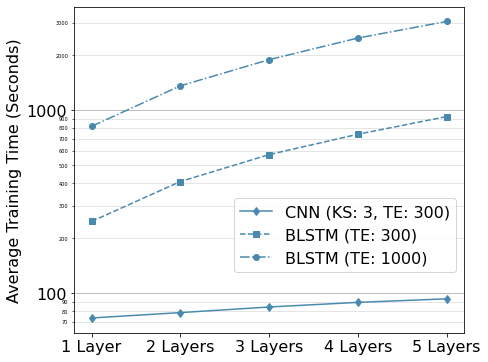

In [128]:
data = [
    {'name': 'CNN (KS: 3, TE: 300)' ,'list': cnn_time},
    {'name': 'BLSTM (TE: 300)' ,'list': blstm_time},
    {'name': 'BLSTM (TE: 1000)' ,'list': blstm_ext_time}
]
plot_time_per_layer(data, save=f'avg_time.{image_format}')

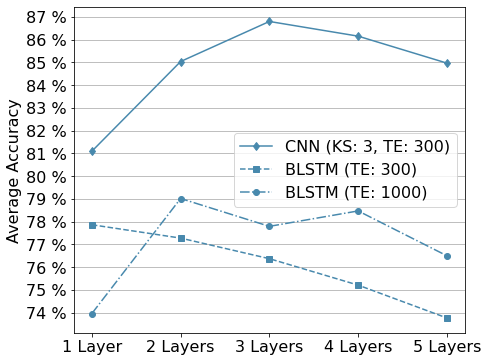

In [129]:
data = [
    {'name': 'CNN (KS: 3, TE: 300)' ,'list': acc_cnn_arr_mean},
    {'name': 'BLSTM (TE: 300)' ,'list': acc_blstm_arr_mean},
    {'name': 'BLSTM (TE: 1000)' ,'list': acc_blstm_ext_arr_mean}
]
plot_accuracy_per_layer(data, save=f'avg_acc.{image_format}')

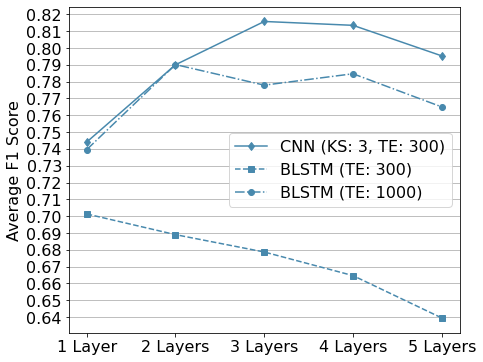

In [130]:
data = [
    {'name': 'CNN (KS: 3, TE: 300)' ,'list': f1_cnn_arr_mean},
    {'name': 'BLSTM (TE: 300)' ,'list': f1_blstm_arr_mean},
    {'name': 'BLSTM (TE: 1000)' ,'list': f1_blstm_ext_arr_mean}
]
plot_f1_per_layer(data, save=f'avg_f1.{image_format}')

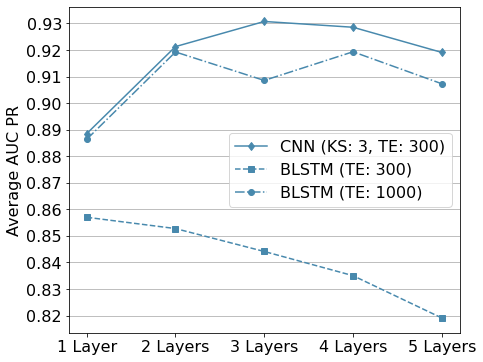

In [131]:
data = [
    {'name': 'CNN (KS: 3, TE: 300)' ,'list': auc_pr_cnn_arr_mean},
    {'name': 'BLSTM (TE: 300)' ,'list': auc_pr_blstm_arr_mean},
    {'name': 'BLSTM (TE: 1000)' ,'list': auc_pr_blstm_ext_arr_mean}
]
plot_auc_pr_per_layer(data, save=f'avg_auc_pr.{image_format}')

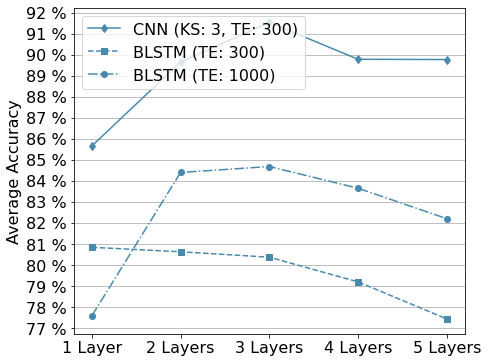

In [132]:
data = [
    {'name': 'CNN (KS: 3, TE: 300)' ,'list': acc_cnn_arr_max},
    {'name': 'BLSTM (TE: 300)' ,'list': acc_blstm_arr_max},
    {'name': 'BLSTM (TE: 1000)' ,'list': acc_blstm_ext_arr_max}
]
plot_accuracy_per_layer(data)

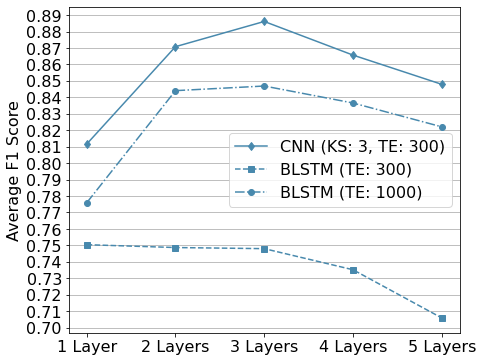

In [133]:
data = [
    {'name': 'CNN (KS: 3, TE: 300)' ,'list': f1_cnn_arr_max},
    {'name': 'BLSTM (TE: 300)' ,'list': f1_blstm_arr_max},
    {'name': 'BLSTM (TE: 1000)' ,'list': f1_blstm_ext_arr_max}
]
plot_f1_per_layer(data)

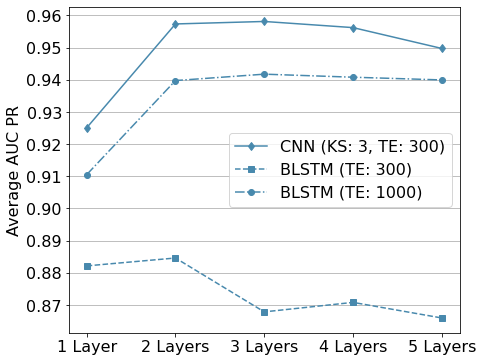

In [134]:
data = [
    {'name': 'CNN (KS: 3, TE: 300)' ,'list': auc_pr_cnn_arr_max},
    {'name': 'BLSTM (TE: 300)' ,'list': auc_pr_blstm_arr_max},
    {'name': 'BLSTM (TE: 1000)' ,'list': auc_pr_blstm_ext_arr_max}
]
plot_auc_pr_per_layer(data)